In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is available and memory growth is set.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found. Using CPU.")


2024-10-12 22:48:36.682032: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-12 22:48:37.031536: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-12 22:48:37.124259: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-12 22:48:37.153631: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-12 22:48:37.370500: I tensorflow/core/platform/cpu_feature_guar

GPU is available and memory growth is set.


I0000 00:00:1728755324.358877    6246 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728755324.624329    6246 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728755324.624391    6246 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50, VGG19, EfficientNetB0, EfficientNetB3
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, InputLayer, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard
import os
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Activation

import datetime
import matplotlib.pyplot as plt
from keras_tuner import RandomSearch
from keras import regularizers
from tensorflow import keras


In [3]:
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image, label


In [4]:
import tensorflow as tf

train_dir = '/mnt/e/Documents/Course/Deep Learning/Projects/Deep Learning Projects/CancerDetection/Dataset/train'  
val_dir = '/mnt/e/Documents/Course/Deep Learning/Projects/Deep Learning Projects/CancerDetection/Dataset/val' 

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred', 
    label_mode='binary',   
    image_size=(224, 224),  
    batch_size=32, 
    shuffle=True,  
    seed=42,  
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='binary',
    image_size=(224, 224),
    batch_size=32,
    shuffle=True,
    seed=42,
)

class_names = train_dataset.class_names
print("Class names:", class_names)


Found 4946 files belonging to 2 classes.


I0000 00:00:1728755335.884845    6246 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728755335.884967    6246 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728755335.884991    6246 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728755338.223583    6246 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728755338.223769    6246 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-12

Found 120 files belonging to 2 classes.
Class names: ['Normal', 'OSCC']


In [5]:
train_dataset = train_dataset.map(augment_image)

In [6]:
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

/tmp/ipykernel_6246/3043687703.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(class_names[int(labels[random_index].numpy())])
2024-10-12 22:49:03.692191: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


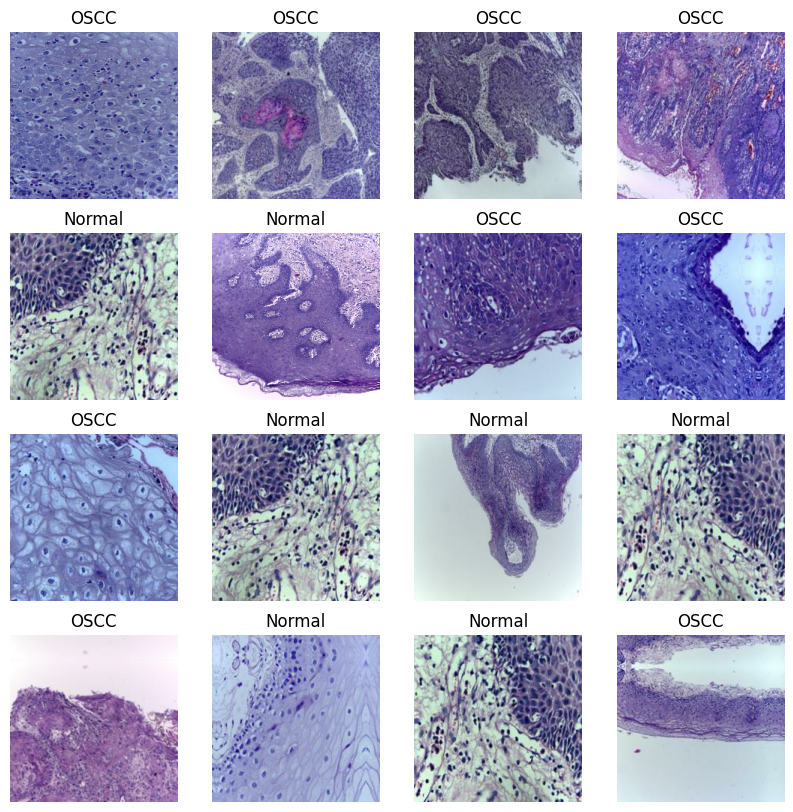

In [7]:
def display_random_images(dataset, num_images=16):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1): 
        for i in range(num_images):
            ax = plt.subplot(4, 4, i + 1)
            random_index = np.random.randint(0, images.shape[0]) 
            plt.imshow(images[random_index].numpy().astype("uint8"))  
            plt.title(class_names[int(labels[random_index].numpy())]) 
            plt.axis("off")

display_random_images(train_dataset, num_images=16)
plt.show()

In [8]:
early_stopping = EarlyStopping(monitor="val_loss", patience = 10, restore_best_weights=True)

In [9]:
total_layers = len(base_model.layers)
print(total_layers)

NameError: name 'base_model' is not defined

In [12]:
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[:30]:
    layer.trainable = False

for layer in base_model.layers[30:]:
    layer.trainable = True

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(64,activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),  
    Dropout(0.5),  
    Dense(1, activation='sigmoid')  
])

optimizer = Adam(learning_rate = 1e-3)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 7, 7, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        98,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,882,224 (41.51 MB)

 Trainable params: 10,790,129 (41.16 MB)

 Non-trainable params: 92,095 (359.75 KB)

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=500,
    callbacks=[early_stopping]
)

Epoch 1/500


I0000 00:00:1728755461.620277    6341 service.cc:146] XLA service 0x7f57a803cf20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728755461.620593    6341 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 6GB Laptop GPU, Compute Capability 8.6
2024-10-12 22:51:03.427424: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-12 22:51:09.663675: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-10-12 22:51:19.703956: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_35000', 144 bytes spill stores, 144 bytes spill loads

2024-10-12 22:51:19.870488: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to loca

154/155 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.7774 - loss: 1.6120

2024-10-12 22:53:27.237194: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_35000', 4 bytes spill stores, 4 bytes spill loads

2024-10-12 22:53:27.728939: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_35000', 8 bytes spill stores, 8 bytes spill loads

2024-10-12 22:53:27.818559: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_35000', 172 bytes spill stores, 172 bytes spill loads

2024-10-12 22:53:28.119481: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_35494', 32 bytes spill stores, 32 bytes spill loads



155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 912ms/step - accuracy: 0.7779 - loss: 1.6098

2024-10-12 22:55:09.702950: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3254', 8 bytes spill stores, 8 bytes spill loads

2024-10-12 22:55:09.923921: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3254', 4 bytes spill stores, 4 bytes spill loads

2024-10-12 22:55:09.963460: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3254', 172 bytes spill stores, 172 bytes spill loads



155/155 ━━━━━━━━━━━━━━━━━━━━ 318s 1s/step - accuracy: 0.7783 - loss: 1.6075 - val_accuracy: 0.8333 - val_loss: 1.2837
Epoch 2/500
155/155 ━━━━━━━━━━━━━━━━━━━━ 38s 243ms/step - accuracy: 0.9220 - loss: 0.6416 - val_accuracy: 0.8833 - val_loss: 0.5056
Epoch 3/500
155/155 ━━━━━━━━━━━━━━━━━━━━ 40s 239ms/step - accuracy: 0.9514 - loss: 0.3045 - val_accuracy: 0.9000 - val_loss: 0.3854
Epoch 4/500
155/155 ━━━━━━━━━━━━━━━━━━━━ 38s 241ms/step - accuracy: 0.9539 - loss: 0.1902 - val_accuracy: 0.8833 - val_loss: 0.3620
Epoch 5/500
155/155 ━━━━━━━━━━━━━━━━━━━━ 38s 245ms/step - accuracy: 0.9560 - loss: 0.1517 - val_accuracy: 0.9000 - val_loss: 0.3552
Epoch 6/500
155/155 ━━━━━━━━━━━━━━━━━━━━ 38s 241ms/step - accuracy: 0.9490 - loss: 0.1668 - val_accuracy: 0.9083 - val_loss: 0.3983
Epoch 7/500
155/155 ━━━━━━━━━━━━━━━━━━━━ 38s 244ms/step - accuracy: 0.9654 - loss: 0.1160 - val_accuracy: 0.8917 - val_loss: 0.3425
Epoch 8/500
155/155 ━━━━━━━━━━━━━━━━━━━━ 38s 245ms/step - accuracy: 0.9672 - loss: 0.1180 

In [ ]:


# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [ ]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/mnt/e/Documents/Course/Deep Learning/Projects/Deep Learning Projects/CancerDetection/Dataset/test",
    labels='inferred',
    label_mode='binary',
    image_size=(224, 224),
    batch_size=32,
    shuffle=True,
    seed=42,
)

In [ ]:
import numpy as np

# Assuming test_dataset is your dataset loaded with image_dataset_from_directory
y_true = []
y_pred = []

# Loop through the dataset and collect true labels (y_true)
for images, labels in test_dataset:
    y_true.extend(labels.numpy())  # Extract true labels (y_true)

# Get predicted probabilities from the model
y_pred_prob = model.predict(test_dataset)

# Convert predicted probabilities to class labels (y_pred)
# For binary classification, we assume a threshold of 0.5
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary labels (0 or 1)

# Convert y_true list to a numpy array
y_true = np.array(y_true)

print(f"True labels: {y_true}")
print(f"Predicted labels: {y_pred}")



In [ ]:
!pip install scikit-learn


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming `y_true` are true labels and `y_pred` are predicted labels
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()
